# Introduction

This notebook demonstrates how to refit a MEGNet formation energy model using PyTorch Lightning with MatGL.

In [ ]:
from __future__ import annotations

import os
import shutil
import warnings
import zipfile

import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch
from dgl.data.utils import split_dataset
from pymatgen.core import Structure
from pytorch_lightning.loggers import CSVLogger
from tqdm import tqdm

from matgl.ext.pymatgen import Structure2Graph, get_element_list
from matgl.graph.data import MEGNetDataset, MGLDataLoader, collate_fn
from matgl.layers import BondExpansion
from matgl.models import MEGNet
from matgl.utils.io import RemoteFile
from matgl.utils.training import ModelLightningModule

# To suppress warnings for clearer output
warnings.simplefilter("ignore")

# Dataset Preparation

We will download the original dataset used in the training of the MEGNet formation energy model (MP.2018.6.1) from figshare. To make it easier, we will also cache the data.

In [ ]:
def load_dataset() -> tuple[list[Structure], list[str], list[float]]:
    """Raw data loading function.

    Returns:
        tuple[list[Structure], list[str], list[float]]: structures, mp_id, Eform_per_atom
    """
    if not os.path.exists("mp.2018.6.1.json"):
        f = RemoteFile("https://figshare.com/ndownloader/files/15087992")
        with zipfile.ZipFile(f.local_path) as zf:
            zf.extractall(".")
    data = pd.read_json("mp.2018.6.1.json")
    structures = []
    mp_ids = []
    for mid, structure_str in tqdm(zip(data["material_id"], data["structure"])):
        struct = Structure.from_str(structure_str, fmt="cif")
        structures.append(struct)
        mp_ids.append(mid)

    return structures, mp_ids, data["formation_energy_per_atom"].tolist()


structures, mp_ids, eform_per_atom = load_dataset()

For demonstration purposes, we are only going to select 100 structures from the entire set of structures to shorten the training time.

In [ ]:
structures = structures[:100]
eform_per_atom = eform_per_atom[:100]

69239it [02:56, 392.16it/s] 


Here, we set up the dataset.

In [ ]:
# get element types in the dataset
elem_list = get_element_list(structures)
# setup a graph converter
converter = Structure2Graph(element_types=elem_list, cutoff=4.0)
# convert the raw dataset into MEGNetDataset
mp_dataset = MEGNetDataset(
    structures, eform_per_atom, "Eform", converter=converter, initial=0.0, final=5.0, num_centers=100, width=0.5
)

We will then split the dataset into training, validation and test data.

In [ ]:
train_data, val_data, test_data = split_dataset(
    mp_dataset,
    frac_list=[0.8, 0.1, 0.1],
    shuffle=True,
    random_state=42,
)
train_loader, val_loader, test_loader = MGLDataLoader(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    collate_fn=collate_fn,
    batch_size=2,
    num_workers=1,
)

100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 680.77it/s]


# Model setup

In the next step, we setup the model and the ModelLightningModule. Here, we have initialized a MEGNet model from scratch. Alternatively, you can also load one of the pre-trained models for transfer learning, which may speed up the training.

In [ ]:
# setup the embedding layer for node attributes
node_embed = torch.nn.Embedding(len(elem_list), 16)
# define the bond expansion
bond_expansion = BondExpansion(rbf_type="Gaussian", initial=0.0, final=5.0, num_centers=100, width=0.5)

# setup the architecture of MEGNet model
model = MEGNet(
    dim_node_embedding=16,
    dim_edge_embedding=100,
    dim_state_embedding=2,
    nblocks=3,
    hidden_layer_sizes_input=(64, 32),
    hidden_layer_sizes_conv=(64, 64, 32),
    nlayers_set2set=1,
    niters_set2set=2,
    hidden_layer_sizes_output=(32, 16),
    is_classification=False,
    activation_type="softplus2",
    bond_expansion=bond_expansion,
    cutoff=4.0,
    gauss_width=0.5,
)

# setup the MEGNetTrainer
lit_module = ModelLightningModule(model=model)

# Training

Finally, we will initialize the Pytorch Lightning trainer and run the fitting. Note that the max_epochs is set at 20 to demonstrate the fitting on a laptop. A real fitting should use max_epochs > 100 and be run in parallel on GPU resources. For the formation energy, it should be around 2000. The `accelerator="cpu"` was set just to ensure compatibility with M1 Macs. In a real world use case, please remove the kwarg or set it to cuda for GPU based training. You may also need to use `torch.set_default_device("cuda")` or `with torch.device("cuda")` to ensure all data are loaded onto the GPU for training.

We have also initialized the Pytorch Lightning Trainer with a `CSVLogger`, which provides a detailed log of the loss metrics at each epoch.

In [ ]:
logger = CSVLogger("logs", name="MEGNet_training")
trainer = pl.Trainer(max_epochs=20, accelerator="cpu", logger=logger)
trainer.fit(model=lit_module, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/MEGNet_training

  | Name  | Type              | Params
--------------------------------------------
0 | model | MEGNet            | 189 K 
1 | mae   | MeanAbsoluteError | 0     
2 | rmse  | MeanSquaredError  | 0     
--------------------------------------------
189 K     Trainable params
100       Non-trainable params
189 K     Total params
0.758     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


# Visualizing the convergence

Finally, we can plot the convergence plot for the loss metrics. You can see that the MAE is already going down nicely with 20 epochs. Obviously, this is nowhere state of the art performance for the formation energies, but a longer training time should lead to results consistent with what was reported in the original MEGNet work.

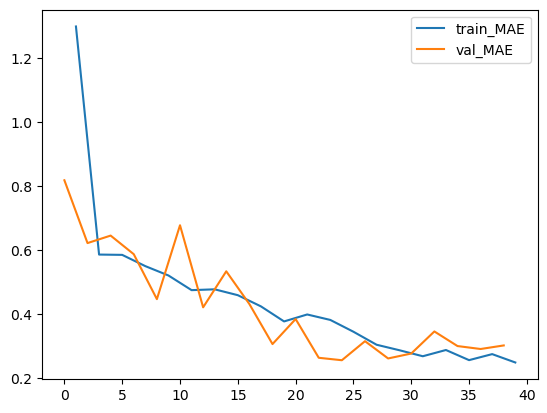

In [ ]:
metrics = pd.read_csv("logs/MEGNet_training/version_0/metrics.csv")
metrics["train_MAE"].dropna().plot()
metrics["val_MAE"].dropna().plot()

_ = plt.legend()

In [ ]:
# This code just performs cleanup for this notebook.

for fn in ("dgl_graph.bin", "dgl_line_graph.bin", "state_attr.pt", "labels.json"):
    try:
        os.remove(fn)
    except FileNotFoundError:
        pass

shutil.rmtree("logs")